In [1]:
%matplotlib notebook
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import os
import warnings 
import sys
sys.path.insert(0, os.path.join('../'))

warnings.filterwarnings('ignore')
from h5py import File
import numpy as np

import karabo_data as kd
from geoAssembler import Calibrate
from geoAssembler.geometry import AGIPD_1MGeometry

## The get an example with interesting data

The example *instrument* has a some runs with interesting data. Run 273 contains data with diffraction patterns from Lithium Titanium. First open this run with karabo-data and read the data


In [2]:
exmpl_dir = '/gpfs/exfel/exp/XMPL/201750/p700000/proc/r0273'
run = kd.RunDirectory(exmpl_dir)
tId, train_data = run.train_from_index(3)

The detector data is stored in *SPB_DET_AGIPD1M-1/DET/**modn**CH0:xtdf* where **modn** is the module number (0-15). Read the data and create a sum over all pulses (176 per train).

In [3]:
train_data['SPB_DET_AGIPD1M-1/DET/15CH0:xtdf']['image.data'].shape

(176, 512, 128)

In [4]:
data_ary = np.empty((16, 512, 128))
for mod in range(16):
    data_ary[mod] = np.nanmean(train_data['SPB_DET_AGIPD1M-1/DET/{}CH0:xtdf'.format(mod)]['image.data'], axis=0)

### Start the geometry calibration with
First lets assume that we have no prior knowledge about the detector geometry. We naively just assume that all modules equally spaced with 29px distance to each other.

<IPython.core.display.Javascript object>


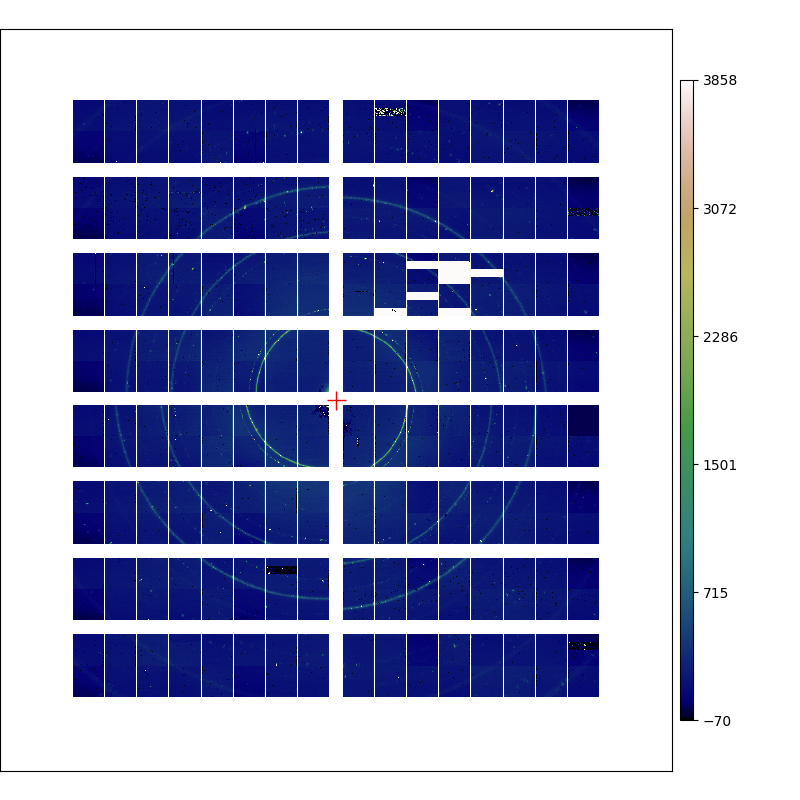

In [24]:
C =  Calibrate(data_ary, figsize=(8,8), bg='w')

### Geometry calibration with a starting geometry
Now lets assume there is a geometry calibration

In [21]:
C.centre

array([614, 540])